# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end


┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


0

## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
#Mode10 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode10/Mode10.json");
Models = [SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode$i/Mode$i.json") for i in 1:10]
device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
χ_e(model) = (model.dressed_energies[(1,1)]-model.dressed_energies[(0,1)])-(model.dressed_energies[(1,0)]-model.dressed_energies[(0,0)]);
χ_f(model) = (model.dressed_energies[(2,1)]-model.dressed_energies[(0,1)])-(model.dressed_energies[(2,0)]-model.dressed_energies[(0,0)]);

# Comparison Plots

In [5]:
Model_f0g1_ft = [Models[i].Stuff["op_drive_params"]["sb_f0g1"]["pulse_time"]-2*Models[i].Stuff["op_drive_params"]["sb_f0g1"]["Envelope Args"]["ramp_time"] for i in 1:10];
Model_f0g1_eps = [Models[i].Stuff["op_drive_params"]["sb_f0g1"]["epsilon"] for i in 1:10];


Device_f0g1_ft= [device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][i][1] for i in 1:10]*1000;
Device_f0g1_gains= [device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_gains"][i][1] for i in 1:10];

Device_f0g1_eps = Device_f0g1_gains


10-element Vector{Int64}:
 13235
 20048
 26035
 22203
 26020
 13267
 15442
 15600
 15970
 30000

In [6]:
println(Device_f0g1_eps)
println(Model_f0g1_eps)

[13235, 20048, 26035, 22203, 26020, 13267, 15442, 15600, 15970, 30000]
[0.295, 0.595, 0.735, 0.84, 1.21, 0.7705, 1.22, 1.545, 1.68, 2.5]


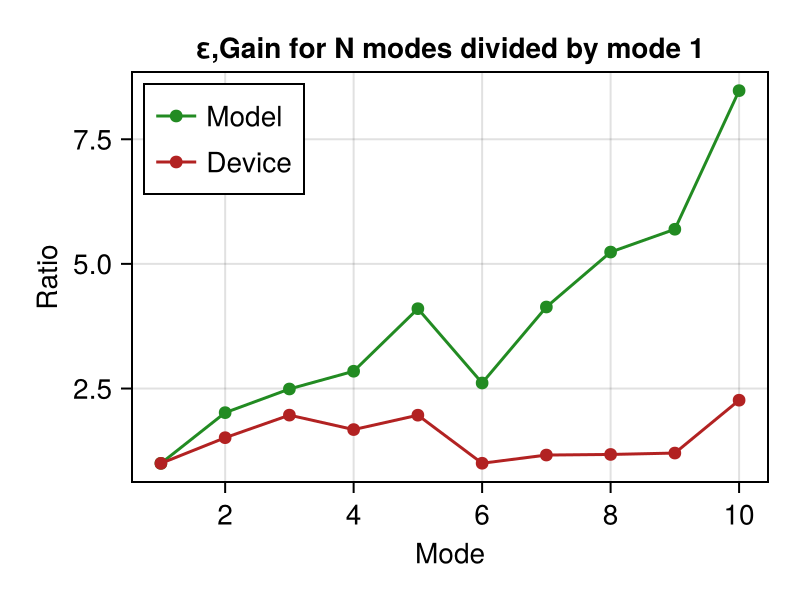

CairoMakie.Screen{IMAGE}


In [7]:
f = cm.Figure(size = (400, 300))
ax = cm.Axis(f[1,1], xlabel = "Mode", ylabel = "Ratio", title = "ε,Gain for N modes divided by mode 1")

dat = (Model_f0g1_eps./Model_f0g1_eps[1])
cm.scatterlines!(ax, dat, color = "forestgreen", label = "Model")

dat = Device_f0g1_eps/Device_f0g1_eps[1]#.*(collect(1:10))/2
cm.scatterlines!(ax, dat, color = "firebrick", label = "Device")

cm.axislegend(ax, position=:lt)
display(f)

In [68]:
i = 8
χ = χ_e(Models[i])
ε = Models[i].Stuff["op_drive_params"]["sb_f0g1"]["epsilon"]
g = Models[i].params["gs"][1]

ωq = Models[i].dressed_energies[(1,0)]-Models[i].dressed_energies[(0,0)]
Δ = (ωq) - Models[i].params["E_oscs"][1]
K = Models[i].dressed_energies[(2,0)] - Models[i].dressed_energies[(1,0)] - (Models[i].dressed_energies[(1,0)]-Models[i].dressed_energies[(0,0)])

Gsb = (ωq-K+Δ)/(2*ωq-K+Δ)*(ε*χ/g)*2
println(1/Gsb)
println(Models[i].Stuff["op_drive_params"]["sb_f0g1"]["pulse_time"])

-301.26255309210876
304.0189696434496


In [69]:
function Theoretical_f0g1(model)
    χ = χ_e(model)
    ε = model.Stuff["op_drive_params"]["sb_f0g1"]["epsilon"]
    g = model.params["gs"][1]

    ωq = model.dressed_energies[(1,0)]-model.dressed_energies[(0,0)]
    Δ = (ωq) - model.params["E_oscs"][1]
    K = model.dressed_energies[(2,0)] - model.dressed_energies[(1,0)] - (model.dressed_energies[(1,0)]-model.dressed_energies[(0,0)])

    Gsb = (ωq-K+Δ)/(2*ωq-K+Δ)*(ε*χ/g)*2
    return 1/Gsb
end

Theoretical_f0g1 (generic function with 1 method)

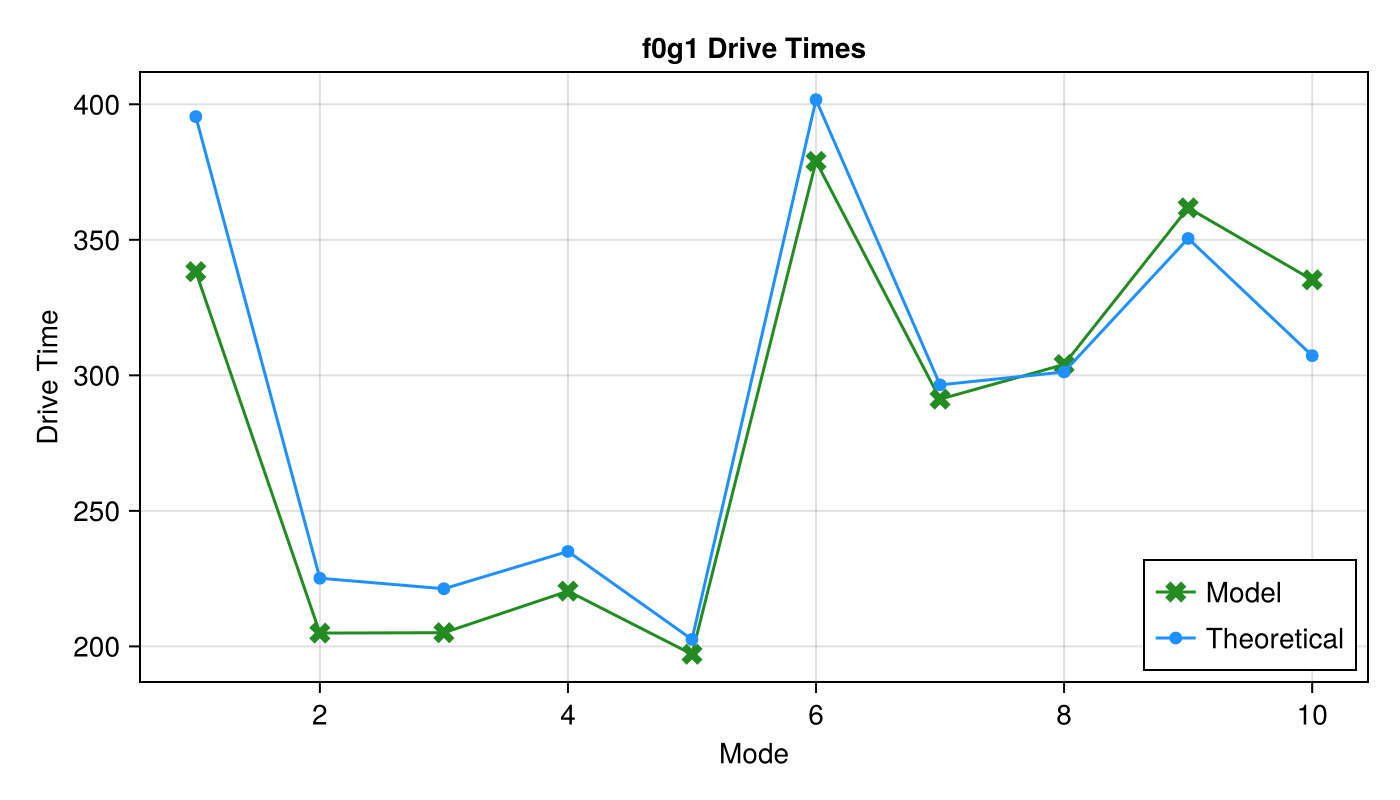

CairoMakie.Screen{IMAGE}


In [85]:
f = cm.Figure(size = (700, 400))
ax = cm.Axis(f[1,1], xlabel = "Mode", ylabel = "Drive Time", title = "f0g1 Drive Times")

y = [Models[i].Stuff["op_drive_params"]["sb_f0g1"]["pulse_time"] for i in 1:10]
cm.scatterlines!(ax, y, color = "forestgreen", label = "Model", marker = :x, markersize = 15)

y = abs.([Theoretical_f0g1(Models[i]) for i in 1:10])
cm.scatterlines!(ax, y, color = "dodgerblue", label = "Theoretical")

cm.axislegend(ax, position=:rb)
display(f)